In [1]:
# %load plot_template.py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

plt.rc('font', family='serif')
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=10, color='grey')
plt.rc('ytick', labelsize=10, color='grey')
plt.rc('legend', fontsize=12, loc='lower left')
plt.rc('figure', titlesize=12)
plt.rc('savefig', dpi=330, bbox='tight')
%matplotlib inline

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
from sklearn.ensemble import RandomForestRegressor

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPRegressor

In [4]:
# Replace PATH_TO_ROOT

import sys
PATH_TO_ROOT = 'C:/Users/walter/Desktop/git/City-Scale-Electricity-Use-Prediction'
sys.path.insert(0,PATH_TO_ROOT)

In [5]:
def train_test_split(data_array, train_ratio=0.75):
    n_train = int(len(data_array)*train_ratio)
    data_train = data_array[:n_train,:]
    data_test = data_array[n_train:,:]
    return data_train, data_test

def generate_fig_path(fig_name):
    '''
    Generate the figure path and name
    To be used by plt.savefig function
    '''
    return '{}/results/fig/section3.4 tabular data model/{}'.format(PATH_TO_ROOT, fig_name)

def generate_input_data_path(data_name):
    '''
    Generate the path to input data
    '''
    return '{}/results/data/{}.csv'.format(PATH_TO_ROOT, data_name)

def generate_result_data_path(data_name):
    '''
    Generate the path to save the result data
    '''
    return '{}/results/data/predict/{}.csv'.format(PATH_TO_ROOT, data_name)

In [6]:
def otherML_train(region):

    # read the data
    data = pd.read_csv(generate_input_data_path(f'{region}_daily'), index_col=0)
    data.index = pd.to_datetime(data.index)
    data = data.truncate(after='2019-07-01')  # do not use the last year to avoid the influence of COVID
    data = data[['Electricity demand, daily sum, (GWh)',
                 'Temperature, daily mean (degC)',
                 'Temperature, daily peak (degC)',
                 'Holiday']].dropna()
    data_ml = np.concatenate((data[['Electricity demand, daily sum, (GWh)',
                                    'Temperature, daily mean (degC)',
                                    'Temperature, daily peak (degC)']].values,
                              data[['Holiday']].astype('int').values,
                              pd.get_dummies(data.index.weekday).values, 
                              pd.get_dummies(data.index.month).values), axis=1)

    # train test split
    data_train, data_test = train_test_split(data_ml, train_ratio=0.75)
    X_train = data_train[:,1:]
    y_train = data_train[:,:1]
    X_test = data_test[:,1:]
    y_test = data_test[:,:1]
    X_all = np.concatenate((X_train, X_test), axis=0)

    # train the RF model
    regr_rf = RandomForestRegressor(max_depth=8, min_samples_leaf=5, max_features='auto')
    regr_rf.fit(X_train, y_train)
    rmse_train_rf = mean_squared_error(regr_rf.predict(X_train), y_train)**0.5
    rmse_test_rf = mean_squared_error(regr_rf.predict(X_test), y_test)**0.5
    print(f'-------Random Forest: {region}--------------')
    print(f'RMSE for Train: {rmse_train_rf}')
    print(f'RMSE for Test: {rmse_test_rf}')

    # train the SVM model 
    regr_svr = make_pipeline(StandardScaler(), SVR(C=10.0, epsilon=0.5))
    regr_svr.fit(X_train, y_train)
    rmse_train_svr = mean_squared_error(regr_svr.predict(X_train), y_train)**0.5
    rmse_test_svr = mean_squared_error(regr_svr.predict(X_test), y_test)**0.5
    print(f'-------SVM: {region}--------------')
    print(f'RMSE for Train: {rmse_train_svr}')
    print(f'RMSE for Test: {rmse_test_svr}')

    # train the NN model
    regr_nn = MLPRegressor(hidden_layer_sizes=(32,32,16), activation='relu', 
                           solver='adam', alpha=0.001, max_iter=500, learning_rate='adaptive',
                           learning_rate_init=0.01, shuffle=True)
    regr_nn.fit(X_train, y_train)
    rmse_train_nn = mean_squared_error(regr_nn.predict(X_train), y_train)**0.5
    rmse_test_nn = mean_squared_error(regr_nn.predict(X_test), y_test)**0.5
    print(f'-------Neural Network: {region}--------------')
    print(f'RMSE for Train: {rmse_train_nn}')
    print(f'RMSE for Test: {rmse_test_nn}')    

    # make prediction on the whole data set and save the results for model comparison
    data['yhat_rf'] = regr_rf.predict(X_all)
    data['yhat_svm'] = regr_svr.predict(X_all)
    data['yhat_nn'] = regr_nn.predict(X_all)
    data.to_csv(generate_result_data_path(f'otherML_{region}'))

    # prepare the data for plotting
    verif_plot = data[['Electricity demand, daily sum, (GWh)','yhat_rf','yhat_svm','yhat_nn']]
    verif_plot.rename(columns={'Electricity demand, daily sum, (GWh)':'y'}, inplace=True)
    verif_plot['train'] = False
    verif_plot.iloc[:len(data_train),:]['train'] = True

    return verif_plot

In [7]:
la_otherML = otherML_train('la')
sac_otherML = otherML_train('sac')
ny_otherML = otherML_train('ny')

<ipython-input-6-90c56a3d7d32>:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr_rf.fit(X_train, y_train)


-------Random Forest: la--------------
RMSE for Train: 3.075336455331413
RMSE for Test: 5.695959060182947
-------SVM: la--------------
RMSE for Train: 3.1930932960807406
RMSE for Test: 5.531594751820285

C:\Users\walter\Anaconda3\envs\cityElePaper\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


C:\Users\walter\Anaconda3\envs\cityElePaper\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


-------Neural Network: la--------------
RMSE for Train: 3.6573690198417403
RMSE for Test: 6.073147051005983


C:\Users\walter\Anaconda3\envs\cityElePaper\lib\site-packages\pandas\core\frame.py:4438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-6-90c56a3d7d32>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verif_plot['train'] = False
<ipython-input-6-90c56a3d7d32>:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

-------Random Forest: sac--------------
RMSE for Train: 2.128334890892587
RMSE for Test: 2.6780187031370235
-------SVM: sac--------------
RMSE for Train: 2.3072139870698316
RMSE for Test: 2.1314705898941395


C:\Users\walter\Anaconda3\envs\cityElePaper\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\walter\Anaconda3\envs\cityElePaper\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


-------Neural Network: sac--------------
RMSE for Train: 2.3876636975259933
RMSE for Test: 2.5104881839438398


C:\Users\walter\Anaconda3\envs\cityElePaper\lib\site-packages\pandas\core\frame.py:4438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-6-90c56a3d7d32>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verif_plot['train'] = False
<ipython-input-6-90c56a3d7d32>:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

-------Random Forest: ny--------------
RMSE for Train: 15.58918293563256
RMSE for Test: 21.85568423607174
-------SVM: ny--------------
RMSE for Train: 26.726673963822375
RMSE for Test: 31.797674592851987


C:\Users\walter\Anaconda3\envs\cityElePaper\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\walter\Anaconda3\envs\cityElePaper\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


-------Neural Network: ny--------------
RMSE for Train: 15.197511279626664
RMSE for Test: 18.675700753112867


C:\Users\walter\Anaconda3\envs\cityElePaper\lib\site-packages\pandas\core\frame.py:4438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-6-90c56a3d7d32>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verif_plot['train'] = False
<ipython-input-6-90c56a3d7d32>:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

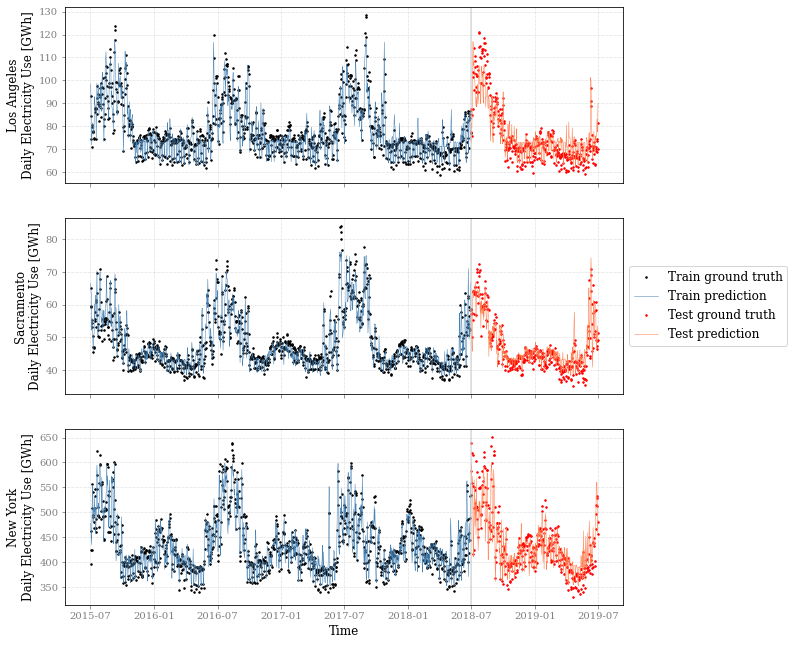

In [8]:
data_all = [la_otherML, sac_otherML, ny_otherML]
cities = ['Los Angeles', 'Sacramento', 'New York']

fig, axes = plt.subplots(3, 1, figsize=(10, 11), sharex=True)

for index in range(3):
    data = data_all[index]
    city = cities[index]
    
    train = data[data['train']]
    axes[index].plot(train.index, train.y, 'ko', markersize=1.5, label='Train ground truth')
    axes[index].plot(train.index, train.yhat_rf, color='steelblue', lw=0.5, label='Train prediction')
    test = data[data['train'] == False]
    axes[index].plot(test.index, test.y, 'ro', markersize=1.5, label='Test ground truth')
    axes[index].plot(test.index, test.yhat_rf, color='coral', lw=0.5, label='Test prediction')

    axes[index].axvline(data[data['train']].index[-1], color='0.8', alpha=0.7)
    axes[index].set_ylabel(f'{city}\nDaily Electricity Use [GWh]')
    axes[index].grid(ls=':', lw=0.5)

axes[1].legend(loc='center left', bbox_to_anchor=(1,0.5))
axes[2].set_xlabel('Time')

plt.savefig(generate_fig_path('Figure A1_rf'))

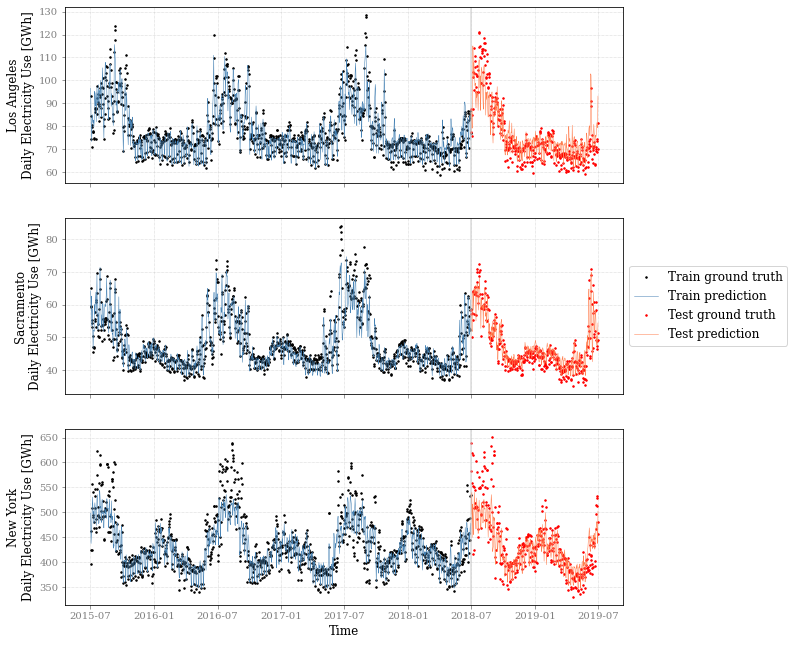

In [9]:
data_all = [la_otherML, sac_otherML, ny_otherML]
cities = ['Los Angeles', 'Sacramento', 'New York']

fig, axes = plt.subplots(3, 1, figsize=(10, 11), sharex=True)

for index in range(3):
    data = data_all[index]
    city = cities[index]
    
    train = data[data['train']]
    axes[index].plot(train.index, train.y, 'ko', markersize=1.5, label='Train ground truth')
    axes[index].plot(train.index, train.yhat_svm, color='steelblue', lw=0.5, label='Train prediction')
    test = data[data['train'] == False]
    axes[index].plot(test.index, test.y, 'ro', markersize=1.5, label='Test ground truth')
    axes[index].plot(test.index, test.yhat_svm, color='coral', lw=0.5, label='Test prediction')

    axes[index].axvline(data[data['train']].index[-1], color='0.8', alpha=0.7)
    axes[index].set_ylabel(f'{city}\nDaily Electricity Use [GWh]')
    axes[index].grid(ls=':', lw=0.5)

axes[1].legend(loc='center left', bbox_to_anchor=(1,0.5))
axes[2].set_xlabel('Time')

plt.savefig(generate_fig_path('Figure A2_svm'))

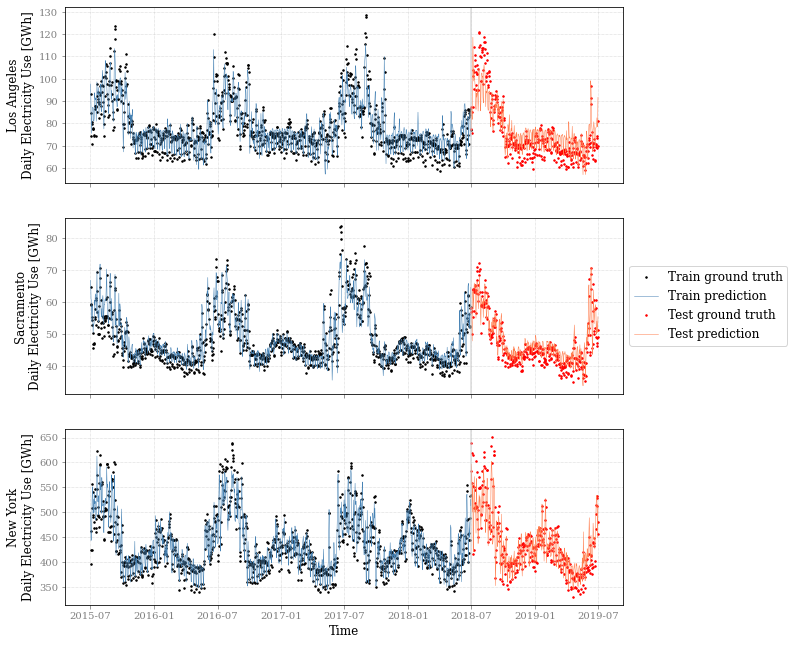

In [10]:
data_all = [la_otherML, sac_otherML, ny_otherML]
cities = ['Los Angeles', 'Sacramento', 'New York']

fig, axes = plt.subplots(3, 1, figsize=(10, 11), sharex=True)

for index in range(3):
    data = data_all[index]
    city = cities[index]
    
    train = data[data['train']]
    axes[index].plot(train.index, train.y, 'ko', markersize=1.5, label='Train ground truth')
    axes[index].plot(train.index, train.yhat_nn, color='steelblue', lw=0.5, label='Train prediction')
    test = data[data['train'] == False]
    axes[index].plot(test.index, test.y, 'ro', markersize=1.5, label='Test ground truth')
    axes[index].plot(test.index, test.yhat_nn, color='coral', lw=0.5, label='Test prediction')

    axes[index].axvline(data[data['train']].index[-1], color='0.8', alpha=0.7)
    axes[index].set_ylabel(f'{city}\nDaily Electricity Use [GWh]')
    axes[index].grid(ls=':', lw=0.5)

axes[1].legend(loc='center left', bbox_to_anchor=(1,0.5))
axes[2].set_xlabel('Time')

plt.savefig(generate_fig_path('Figure A3_nn'))